In [1]:
import json
import time
from typing import Dict

from datasets import load_dataset
from datasets.formatting.formatting import LazyBatch
from huggingface_hub import list_datasets
import matplotlib.pyplot as plt
from minio import Minio
from minio.datatypes import Object
from minio.helpers import ObjectWriteResult
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
from transformers import AutoModel, AutoTokenizer
from transformers.tokenization_utils_base import BatchEncoding

#### Load Data

In [2]:
emotions = load_dataset('emotion')
type(emotions)

datasets.dataset_dict.DatasetDict

In [3]:
def get_object(bucket_name: str, object_name: str, file_path: str) -> Object:
    '''
    This function will download an object from MinIO to the specified file_path
    and return the object_info.
    '''

    # Load the credentials and connection information.
    with open('credentials.json') as f:
        credentials = json.load(f)

    # Create client with access and secret key
    client = Minio(credentials['url'],  # host.docker.internal
                credentials['accessKey'],  
                credentials['secretKey'], 
                secure=False)
    
    # Get data of an object.
    object_info = client.fget_object(bucket_name, object_name, file_path)

    return object_info


def put_file(bucket_name: str, object_name: str, file_path: str) -> ObjectWriteResult:
    '''
    This function will upload a file to MinIO and return the object_info.
    '''

    # Load the credentials and connection information.
    with open('credentials.json') as f:
        credentials = json.load(f)

    # Create client with access and secret key
    client = Minio(credentials['url'],  # host.docker.internal
                credentials['accessKey'],  
                credentials['secretKey'], 
                secure=False)
    
    # Make sure bucket exists.
    found = client.bucket_exists(bucket_name)
    if not found:
        client.make_bucket(bucket_name)

    # Upload the file.
    object_write_result = client.fput_object(bucket_name, object_name, file_path)

    return object_write_result

In [4]:
bucket_name = 'emotions-data'
for split, dataset in emotions.items():
    dataset.to_json(f'emotions-{split}.jsonl')
    object_write_results = put_file(bucket_name, f'emotions-{split}.jsonl', f'emotions-{split}.jsonl')
    print(object_write_results.object_name, object_write_results.location)

Creating json from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

emotions-train.jsonl None


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

emotions-validation.jsonl None


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

emotions-test.jsonl None


In [5]:
data_files = {}
for split in ['train', 'validation', 'test']:
    data_files[split] = f'emotions-{split}.jsonl'
    object_info = get_object(bucket_name, f'emotions-{split}.jsonl', f'emotions-{split}.jsonl')
    print(object_info.object_name, object_info.last_modified)

emotions = load_dataset('json', data_files=data_files)

emotions-train.jsonl 2023-09-26 14:11:02+00:00
emotions-validation.jsonl 2023-09-26 14:11:02+00:00
emotions-test.jsonl 2023-09-26 14:11:02+00:00


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

#### Data Exploration

In [6]:
emotions.set_format(type='pandas')
df_emotions = emotions['validation'][:]
df_emotions.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


In [7]:
# The line of code below does not work when the DatasetDict is created from files.
#label_name = emotions['train'].features['label'].int2str(label_code)

def label_conversion(label_code: int) -> str:
    label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    return label_names[label_code]

df_emotions['label_name'] = df_emotions['label'].apply(label_conversion)
df_emotions.head()

,text,label,label_name
0,im feeling quite sad and sorry for myself but ...,0,sadness
1,i feel like i am still looking at a blank canv...,0,sadness
2,i feel like a faithful servant,2,love
3,i am just feeling cranky and blue,3,anger
4,i can have for a treat or if i am feeling festive,1,joy


#### Set up the device

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Load the model and get its tokenizer.

In [9]:
model_check_point = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(model_check_point).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_check_point)
print(type(model))
print(type(tokenizer))

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertModel'>
<class 'transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast'>


#### Tokenize the Entire Dataset

In [10]:
emotions.reset_format()
def tokenize(batch) -> BatchEncoding:
    out = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')
    return out

print(type(tokenize(emotions['train'])))

<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [11]:
type(emotions['train'])

datasets.arrow_dataset.Dataset

In [12]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
print(type(emotions_encoded))
emotions_encoded['train'][:2].items()

<class 'datasets.dataset_dict.DatasetDict'>


dict_items([('text', ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake']), ('label', [0, 0]), ('input_ids', [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), ('attention_mask', [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Retrieve Hidden State from Predictions

In [14]:
def extract_hidden_states(batch) -> Dict:
    # Move the model inputs to the appropriate device.
    #print(batch.items())
    #bra
    inputs_dict = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # Call the model and extract the hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs_dict).last_hidden_state
    # Return the vector for the [CLS] token.
    return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

In [15]:
start = time.perf_counter()
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
end = time.perf_counter()
print(f'Inference took {end - start:0.4f} seconds.')

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Inference took 24.5160 seconds.


In [16]:
print(type(emotions_hidden))
emotions_hidden['train'].column_names

<class 'datasets.dataset_dict.DatasetDict'>


['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [17]:
print(type(emotions_encoded))
print(type(emotions_encoded['train']))
print(type(emotions_encoded['train'][:]))
for k,v in emotions_encoded.items():
    print(k, v)

#emotions_encoded.items()

<class 'datasets.dataset_dict.DatasetDict'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'dict'>
train Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})
validation Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})
test Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})


In [18]:
emotions_encoded['train'][0]

{'label': tensor(0),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

#### Create Training set and Validation set from the Hidden State

In [19]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [20]:
logistic_regression = LogisticRegression(max_iter=3000)
logistic_regression.fit(X_train, y_train)
logistic_regression.score(X_valid, y_valid)

0.6335

In [21]:
# This does not work when the DatasetDict is created from files.
#labels = emotions['train'].features['label'].names
#labels

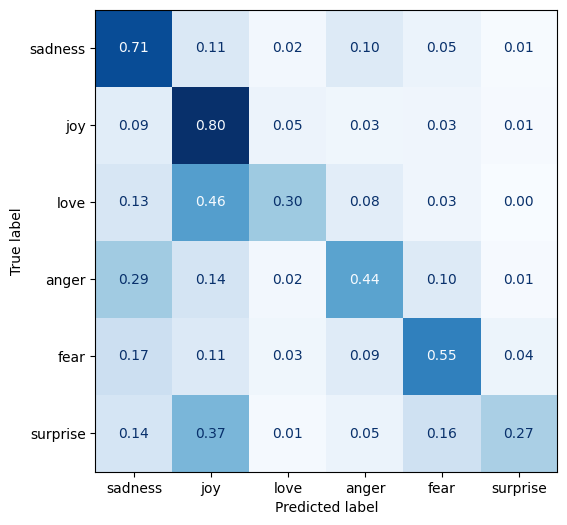

In [22]:
def plot_confusion_matrix(y_predicted, y_true, labels):
    cm = confusion_matrix(y_true, y_predicted, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title = ('Normalized Confusion Matrix')
    plt.show()

labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
y_predictions = logistic_regression.predict(X_valid)
plot_confusion_matrix(y_predictions, y_valid, labels)